In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
df = pd.read_csv('train.csv')
print(df.head())
print(df.info())
print(df.describe())

In [ ]:
# Анализ и заполнение пропусков
df.isnull().sum()

df['Age'].fillna(df['Age'].median(), inplace=True) # заполним пропуски медианой
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True) # заполним пропуски самым частым значением
df.drop(columns=['Cabin'], inplace=True) # удаляем столбец, так как много пропусков
df.isnull().sum().sum()

np.int64(0)

In [ ]:
# Преобразование категориальных признаков
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
df = pd.get_dummies(df, columns=['Embarked'], prefix='Emb') # создание отдельных колонок для каждого порта

print(df[['Sex', 'Emb_C', 'Emb_Q', 'Emb_S']].head())

   Sex  Emb_C  Emb_Q  Emb_S
0    0  False  False   True
1    1   True  False  False
2    1  False  False   True
3    1  False  False   True
4    0  False  False   True


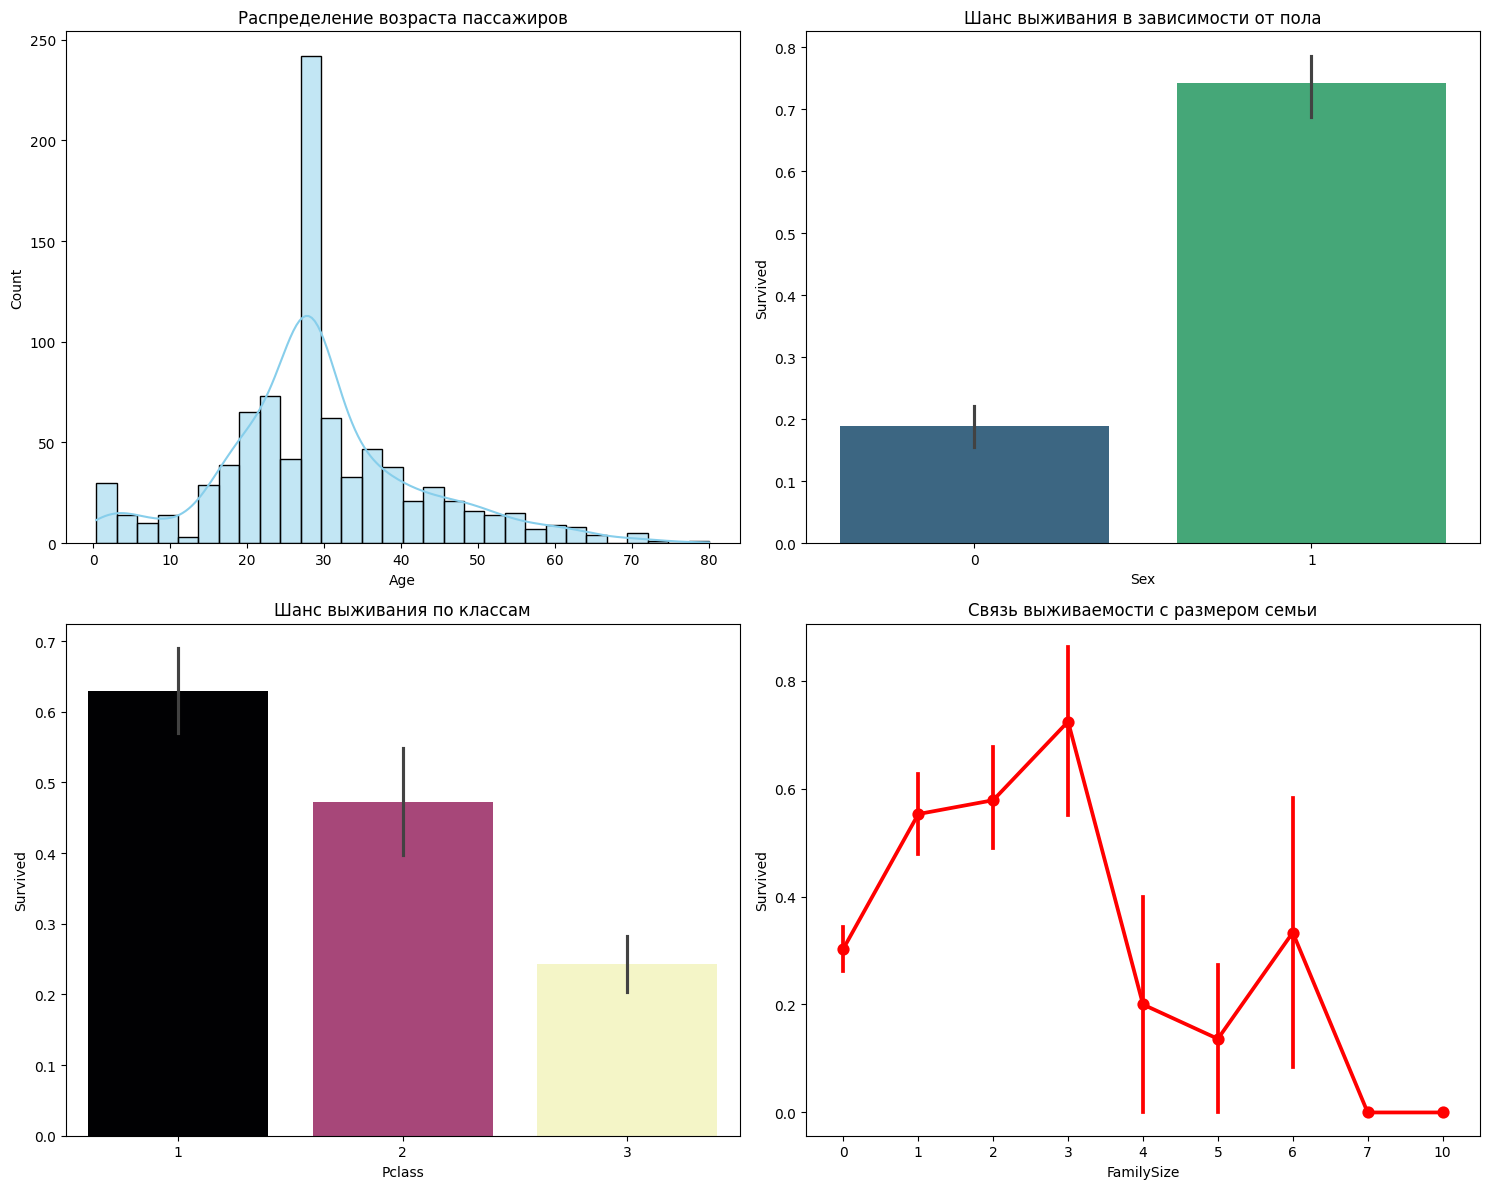

In [ ]:
# Создание нового признака
df['FamilySize'] = df['SibSp'] + df['Parch']
# Визуализация ключевых зависимостей
# Делаем сетку 2 на 2
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Распределение возраста 
sns.histplot(df['Age'], kde=True, ax=axes[0, 0], color='skyblue') # kde - ядерная оценка плотности
axes[0, 0].set_title('Распределение возраста пассажиров')

# 2. Шанс выживания по полу     
sns.barplot(x='Sex', y='Survived', data=df, ax=axes[0, 1], 
            hue='Sex', palette='viridis', legend=False)
axes[0, 1].set_title('Шанс выживания в зависимости от пола')

# 3. Шанс выживания по классам 
sns.barplot(x='Pclass', y='Survived', data=df, ax=axes[1, 0], 
            hue='Pclass', palette='magma', legend=False)
axes[1, 0].set_title('Шанс выживания по классам')

# 4. Влияние размера семьи
sns.pointplot(x='FamilySize', y='Survived', data=df, ax=axes[1, 1], color='r')
axes[1, 1].set_title('Связь выживаемости с размером семьи')

plt.tight_layout() # автоматическое размещение подграфиков
plt.show()

In [ ]:
# Извлечение и обработка титулов из имён пассажиров

# 1. Извлекаем титул из имён, что позволит модели лучше различать группы пассажиров
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\\.', expand=False)

print(df['Title'].value_counts())
# 2. Группируем редкие титулы, чтобы модель не путалась
# Исправляем французские и редкие обращения
df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer'], 'Rare')
df['Title'] = df['Title'].replace('Mlle', 'Miss')
df['Title'] = df['Title'].replace('Ms', 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')

df = pd.get_dummies(df, columns=['Title'], prefix='T')
df.head()

In [7]:
# (E) Обучение модели

features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'Emb_C', 'Emb_Q', 'Emb_S',
            'T_Master', 'T_Miss', 'T_Mr', 'T_Mrs', 'T_Rare']
X = df[features]
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000) 
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred):.2%}")
print("\nОтчёт о классификации:")
print(classification_report(y_test, y_pred))

print("Матрица ошибок:")
print(confusion_matrix(y_test, y_pred))

Logistic Regression Accuracy: 81.01%

Отчёт о классификации:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       105
           1       0.77      0.77      0.77        74

    accuracy                           0.81       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179

Матрица ошибок:
[[88 17]
 [17 57]]


In [8]:
from sklearn.ensemble import RandomForestClassifier

# Инициализируем лес случайных деревьев
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

# Обучаем на готовых признаках X_train
rf_model.fit(X_train, y_train)

# Предсказываем
rf_preds = rf_model.predict(X_test)

print(f"Random Forest Accuracy: {accuracy_score(y_test, rf_preds):.2%}")

Random Forest Accuracy: 82.68%


In [ ]:
test_df = pd.read_csv('test.csv')

# Повторяем предобработу
# в test.csv есть 1 пропуск в Fare, заполним его медианой
test_df['Age'].fillna(test_df['Age'].median(), inplace=True)
test_df['Fare'].fillna(test_df['Fare'].median(), inplace=True) 
test_df.drop(columns=['Cabin'], inplace=True)

test_df['Sex'] = test_df['Sex'].map({'male': 0, 'female': 1})
test_df = pd.get_dummies(test_df, columns=['Embarked'], prefix='Emb')

test_df['FamilySize'] = test_df['SibSp'] + test_df['Parch']
 
test_df['Title'] = test_df['Name'].str.extract(' ([A-Za-z]+)\\.', expand=False)
test_df['Title'] = test_df['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
test_df['Title'] = test_df['Title'].replace(['Mlle', 'Ms'], 'Miss')
test_df['Title'] = test_df['Title'].replace('Mme', 'Mrs')

test_df = pd.get_dummies(test_df, columns=['Title'], prefix='T')

# Синхронизация колонок
"""Бывает так, что в тесте нет какого-то редкого титула, и колонка T_Rare не создастся. А модель ждет именно 15 колонок(признаков).
   Команда reindex принудительно создаст недостающие колонки и заполнит их 0."""

# Используем тот же список features, на котором учился RandomForest
test_X = test_df.reindex(columns=features, fill_value=0)

print("Размер данных для предсказания:", test_X.shape)
print("Колонки совпадают?", list(test_X.columns) == features)

Размер данных для предсказания: (418, 15)
Колонки совпадают? True


In [12]:
# Делаем предсказание
final_predictions = rf_model.predict(test_X)

# Формируем таблицу для отправки (Kaggle формат)
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': final_predictions
})

submission.to_csv('submission.csv', index=False) # cохраняем в файл

print(submission.head())

   PassengerId  Survived
0          892         0
1          893         1
2          894         0
3          895         0
4          896         1


In [13]:
from sklearn.model_selection import cross_val_score

# Проводим кросс-валидацию на 5 фолдах. Мы используем все данные X и y, так как CV сама внутри всё разделит"""
cv_scores = cross_val_score(rf_model, X, y, cv=5)

print(f"Результаты всех тестов: {cv_scores}")
print(f"Средняя точность (Mean CV Accuracy): {cv_scores.mean():.2%}")
print(f"Стандартное отклонение: {cv_scores.std():.4f}")

Результаты всех тестов: [0.83798883 0.82022472 0.8258427  0.80337079 0.85955056]
Средняя точность (Mean CV Accuracy): 82.94%
Стандартное отклонение: 0.0187


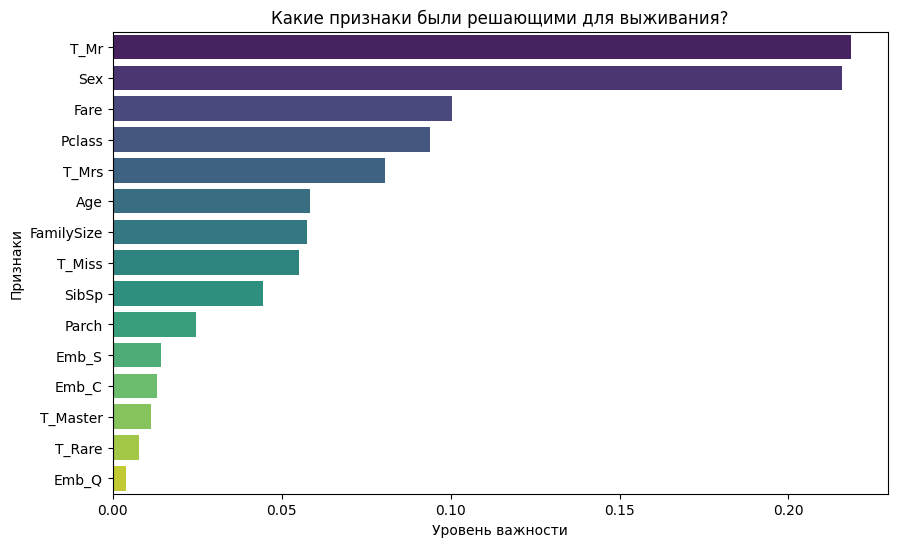

In [15]:
# Получаем веса признаков из модели
importances = pd.Series(rf_model.feature_importances_, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=importances.index, hue=importances.index, palette='viridis', legend=False)
plt.title("Какие признаки были решающими для выживания?")
plt.xlabel("Уровень важности")
plt.ylabel("Признаки")
plt.show()

In [16]:
import joblib

# Сохраняем саму модель
joblib.dump(rf_model, 'titanic_rf_model.pkl')

# Сохраняем список признаков, чтобы не забыть порядок колонок
joblib.dump(features, 'model_features.pkl')


['model_features.pkl']